# Point cloud classification with PointNet

**Description:** Implementation of PointNet for ModelNet10 classification.

# Point cloud classification

## Introduction

Classification, detection and segmentation of unordered 3D point sets i.e. point clouds
is a core problem in computer vision. This example implements the seminal point cloud
deep learning paper [PointNet (Qi et al., 2017)](https://arxiv.org/abs/1612.00593). For a
detailed intoduction on PointNet see [this blog
post](https://medium.com/@luis_gonzales/an-in-depth-look-at-pointnet-111d7efdaa1a).

## Setup

If using colab first install trimesh with `!pip install trimesh`.

In [7]:

import os
import glob
import trimesh
import numpy as np
from tensorflow import data as tf_data
from keras import ops
import keras
from keras import layers
import matplotlib.pyplot as plt

keras.utils.set_random_seed(seed=42)

## Load dataset

We use the ModelNet10 model dataset, the smaller 10 class version of the ModelNet40
dataset. First download the data:

In [12]:
DATA_DIR = keras.utils.get_file(
    "modelnet.zip",
    "http://modelnet.cs.princeton.edu/ModelNet40.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet40")

In [13]:
print(os.listdir)

<built-in function listdir>


We can use the `trimesh` package to read and visualize the `.off` mesh files.

In [14]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

ValueError: string is not a file: /home/mayank/.keras/datasets/ModelNet40/chair/train/chair_0001.off

To convert a mesh file to a point cloud we first need to sample points on the mesh
surface. `.sample()` performs a unifrom random sampling. Here we sample at 2048 locations
and visualize in `matplotlib`.

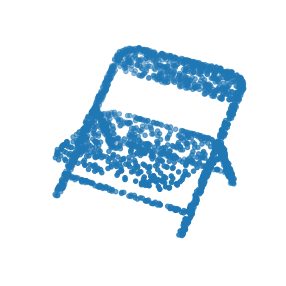

In [6]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

To generate a `tf.data.Dataset()` we need to first parse through the ModelNet data
folders. Each mesh is loaded and sampled into a point cloud before being added to a
standard python list and converted to a `numpy` array. We also store the current
enumerate index value as the object label and use a dictionary to recall this later.

In [7]:

def parse_dataset(num_points=2048):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )


Set the number of points to sample and batch size and parse the dataset. This can take
~5minutes to complete.

In [8]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: dresser
processing class: monitor
processing class: bathtub
processing class: desk
processing class: night_stand
processing class: bed
processing class: table
processing class: chair
processing class: sofa
processing class: toilet


Our data can now be read into a `tf.data.Dataset()` object. We set the shuffle buffer
size to the entire size of the dataset as prior to this the data is ordered by class.
Data augmentation is important when working with point cloud data. We create a
augmentation function to jitter and shuffle the train dataset.

In [9]:

def augment(points, label):
    # jitter points
    points += keras.random.uniform(points.shape, -0.005, 0.005, dtype="float64")
    # shuffle points
    points = keras.random.shuffle(points)
    return points, label


train_size = 0.8
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

dataset = dataset.shuffle(len(train_points)).map(augment)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

2024-04-16 16:00:39.379406: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 16:00:39.509339: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-04-16 16:00:39.512649: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 196165632 exceeds 10% of free system memory.


### Build a model

Each convolution and fully-connected layer (with exception for end layers) consits of
Convolution / Dense -> Batch Normalization -> ReLU Activation.

In [10]:

def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


PointNet consists of two core components. The primary MLP network, and the transformer
net (T-net). The T-net aims to learn an affine transformation matrix by its own mini
network. The T-net is used twice. The first time to transform the input features (n, 3)
into a canonical representation. The second is an affine transformation for alignment in
feature space (n, 3). As per the original paper we constrain the transformation to be
close to an orthogonal matrix (i.e. ||X*X^T - I|| = 0).

In [11]:

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = ops.eye(num_features)

    def __call__(self, x):
        x = ops.reshape(x, (-1, self.num_features, self.num_features))
        xxt = ops.tensordot(x, x, axes=(2, 2))
        xxt = ops.reshape(xxt, (-1, self.num_features, self.num_features))
        return ops.sum(self.l2reg * ops.square(xxt - self.eye))


 We can then define a general function to build T-net layers.

In [12]:

def tnet(inputs, num_features):
    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])


The main network can be then implemented in the same manner where the t-net mini models
can be dropped in a layers in the graph. Here we replicate the network architecture
published in the original paper but with half the number of weights at each layer as we
are using the smaller 10 class ModelNet dataset.

In [13]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2048, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2048, 32)  │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2048, 32)  │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 2048, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 2048, 64)  │      2,112 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048, 64)  │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 2048, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 2048, 512) │     33,280 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048, 512) │      2,048 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 2048, 512) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_2[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 9)         │      1,161 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 3, 3)      │          0 │ dense_2[0][0]   

 Total params: 748,979 (2.86 MB)

 Trainable params: 742,899 (2.83 MB)

 Non-trainable params: 6,080 (23.75 KB)

### Train model

Once the model is defined it can be trained like any other standard classification model
using `.compile()` and `.fit()`.

In [14]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=validation_dataset)

Epoch 1/20


2024-04-16 16:01:12.857041: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 196165632 exceeds 10% of free system memory.
2024-04-16 16:01:18.713426: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2024-04-16 16:01:18.778195: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2024-04-16 16:01:18.824938: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


100/100 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - loss: 44.9237 - sparse_categorical_accuracy: 0.2570 - val_loss: 37.5282 - val_sparse_categorical_accuracy: 0.2203
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - loss: 36.2076 - sparse_categorical_accuracy: 0.3342 - val_loss: 176270749227548672.0000 - val_sparse_categorical_accuracy: 0.3479
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - loss: 36.1898 - sparse_categorical_accuracy: 0.3161 - val_loss: 974578947981312.0000 - val_sparse_categorical_accuracy: 0.4443
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - loss: 35.9093 - sparse_categorical_accuracy: 0.3557 - val_loss: 44576744.0000 - val_sparse_categorical_accuracy: 0.3930
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - loss: 35.7878 - sparse_categorical_accuracy: 0.4104 - val_loss: 13166443934919950336.0000 - val_sparse_categorical_accuracy: 0.4193
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - loss: 35.9748 - sparse_categorical_accuracy: 0.4057 - val_

## Visualize predictions

We can use matplotlib to visualize our trained model performance.

2024-04-16 19:07:50.339581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step


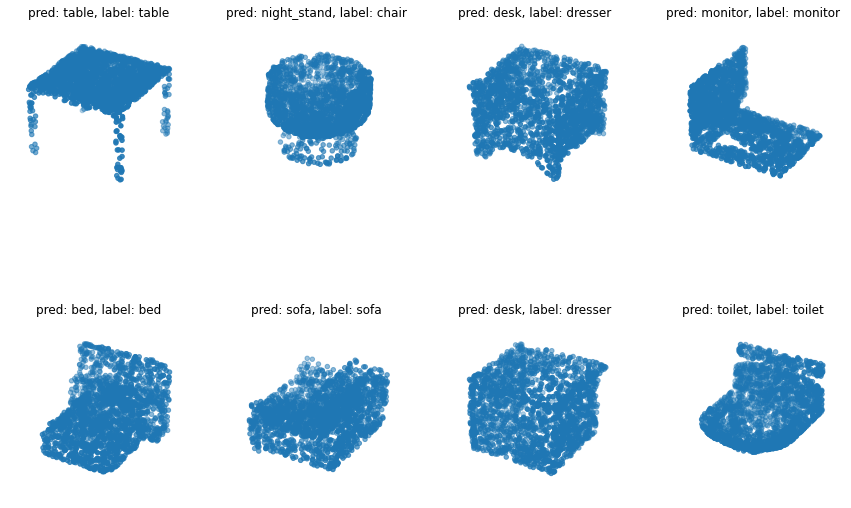

In [15]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()